In [9]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Miscellaneous
from tqdm import tqdm
import os
import random

In [23]:
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
train_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/'

train_paths = []
train_labels = []

for label in labels:
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)
        
tumor_train_df = pd.concat([pd.Series(train_paths, name = 'paths'), 
                            pd.Series(train_labels, name = 'label')], 
                            axis = 1)
tumor_train_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
...,...,...
5707,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma
5708,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma
5709,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma
5710,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma


In [24]:
tumor_train_df.shape

(5712, 2)

In [30]:
tumor_train_df['label'].value_counts(normalize = True)

notumor       0.279237
pituitary     0.255077
meningioma    0.234419
glioma        0.231268
Name: label, dtype: float64

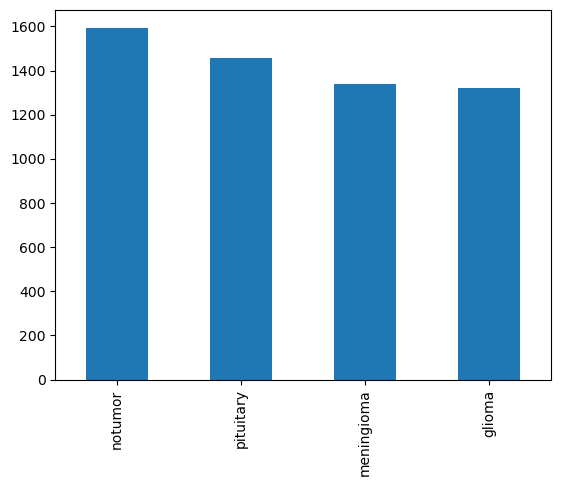

In [25]:
tumor_train_df['label'].value_counts().plot(kind = 'bar');

In [27]:
test_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/'

test_paths = []
test_labels = []

for label in labels:
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)
        
tumor_test_df = pd.concat([pd.Series(test_paths, name = 'paths'), 
                            pd.Series(test_labels, name = 'label')], 
                            axis = 1)
tumor_test_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,pituitary
...,...,...
1306,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma
1307,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma
1308,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma
1309,/Users/eli/Desktop/brain_tumor_CNN_classifier/...,glioma


In [31]:
tumor_test_df['label'].value_counts(normalize = True)

notumor       0.308924
meningioma    0.233410
pituitary     0.228833
glioma        0.228833
Name: label, dtype: float64

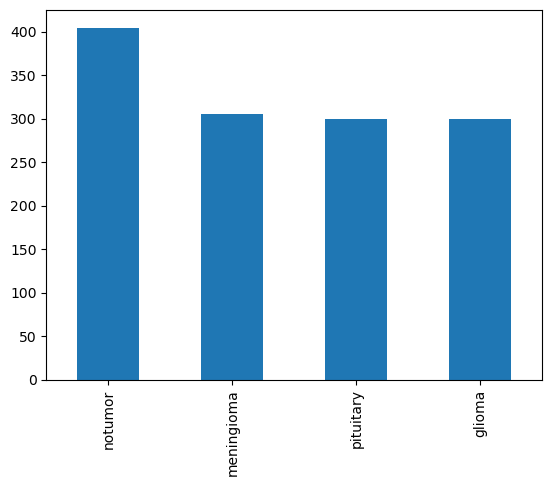

In [28]:
tumor_test_df['label'].value_counts().plot(kind = 'bar');

In [ ]:
# Setting default size of the plot and images
plt.rcParams['figure.figsize'] = (16.0, 16.0)
image_size = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Defining a figure object with number of needed subplots
# ax is a (25, 4) numpy array
# To access specific subplot we call it by ax[0, 0]
figure, ax = plt.subplots(nrows=4, ncols=4)

# Plotting 16 examples along 4 rows and 4 columns
for i in range(4):
    for j in range(4):
        # Preparing random index
        ii = np.random.randint(low=0, high=x_train.shape[0])
        
        # Plotting current subplot
        ax[i, j].imshow(x_train[ii].astype('uint8'))
        
        # Giving name to current subplot
        # according to class's name in dataFrame 'labels'
        ax[i, j].set_title(labels.loc[y_train[ii], 0], fontsize=16)
        
        # Hiding axis
        ax[i, j].axis('off')

# Adjusting distance between subplots and showing plot
plt.tight_layout()
plt.show()

In [ ]:
# check out this repo for edge detection function
# https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16